In [1]:
# Uncomment line below to install exlib
# !pip install exlib
# !pip install diskcache
import sys; sys.path.insert(0, "../../exlib/src")
import exlib

ROOT_DIR = '..'

In [2]:
import torch
from datasets import load_dataset
from exlib.datasets.mass_maps import MassMapsDataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Load data
train_dataset = MassMapsDataset(split="train")
val_dataset = MassMapsDataset(split="validation")

In [5]:
import openai
from getpass import getpass
import os

# with open(f"{ROOT_DIR}/API_KEY.txt", "r") as file:
#     api_key = file.read().strip()

# os.environ['OPENAI_API_KEY'] = api_key
# os.environ['CACHE_DIR'] = "/shared_data0/llm_cachedir"

openai.api_key = getpass('Enter your OpenAI API key: ')
os.environ['OPENAI_API_KEY'] = openai.api_key

Enter your OpenAI API key:  ········


In [18]:
from massmaps import MassMapsExample
from massmaps import massmap_to_pil_norm, get_llm_generated_answer
from massmaps import isolate_individual_features, distill_relevant_features, calculate_expert_alignment_score

# Get Few-shot Examples

In [8]:
train_dataset['label'].min(dim=0), train_dataset['label'].max(dim=0)

(torch.return_types.min(
 values=tensor([0.1004, 0.4002]),
 indices=tensor([164, 319])),
 torch.return_types.max(
 values=tensor([0.4994, 1.3973]),
 indices=tensor([632, 556])))

In [36]:
few_shot_numbers = [0, 1, 14, 19]

In [34]:
for i in range(20):
    print(i, train_dataset['label'][i])

0 tensor([0.1041, 0.9396])
1 tensor([0.3934, 0.7018])
2 tensor([0.2000, 1.1500])
3 tensor([0.4834, 0.6632])
4 tensor([0.1182, 1.3888])
5 tensor([0.3461, 0.6949])
6 tensor([0.4480, 0.5182])
7 tensor([0.2418, 0.7213])
8 tensor([0.4926, 0.4537])
9 tensor([0.4129, 0.4342])
10 tensor([0.2948, 0.4188])
11 tensor([0.4733, 0.5174])
12 tensor([0.3190, 0.9793])
13 tensor([0.2031, 0.8141])
14 tensor([0.3586, 0.9762])
15 tensor([0.2869, 0.5606])
16 tensor([0.2705, 0.8829])
17 tensor([0.3102, 0.8004])
18 tensor([0.4003, 0.4637])
19 tensor([0.4612, 0.5614])


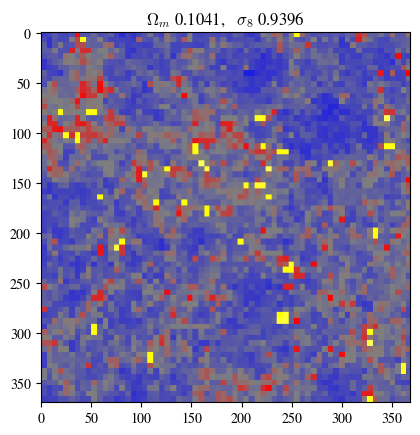

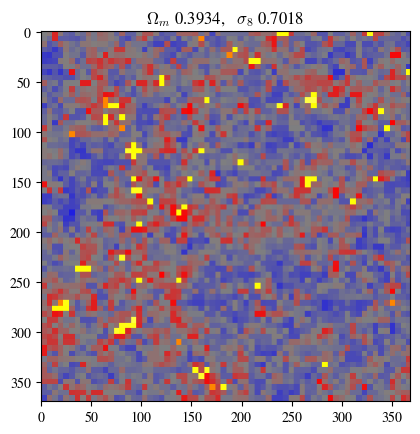

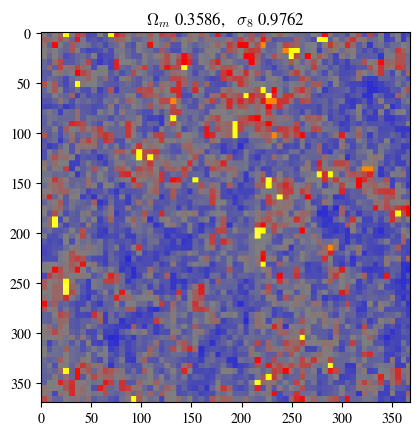

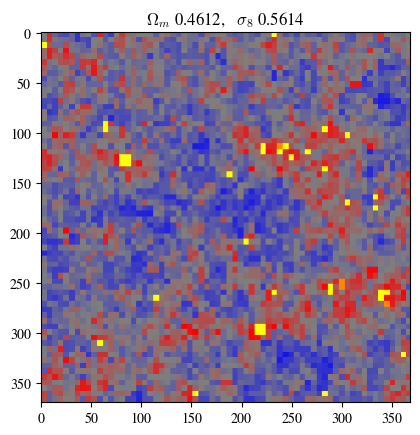

In [44]:
from massmaps import massmap_to_pil_norm
import matplotlib.pyplot as plt

relevance_few_shot_examples = []
for idx in few_shot_numbers:
    X, y = train_dataset[idx:idx+1]['input'], train_dataset[idx:idx+1]['label']
    relevance_few_shot_examples.append({'idx': idx, 'X': X, 'y': y})
    plt.figure()
    plt.imshow(massmap_to_pil_norm(X[0]))
    plt.title(f'$\Omega_m$ {round(y[0][0].item(), 4)},   $\sigma_8$ {round(y[0][1].item(), 4)}')
    plt.show()

In [50]:
relevance_few_shot_examples[0].update({
    'claim': 'The dataset represents the spatial distribution of matter density in the universe.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'This is a general statement and does not justify any specific prediction.'
})
relevance_few_shot_examples[1].update({
    'claim': 'The weak lensing map shows several yellow pixels close to each other on the left side, suggesting the existence of high-density regions or clusters.',
    'relevance_answer': 'YES',
    'relevance_explanation': 'This is a specific cosmological structure observable in the data and indicative of cosmological parameters such as sigma_8.'
})
relevance_few_shot_examples[2].update({
    'claim': 'Voids are large low density regions in space.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'This is background knowledge, not derived from the data.'
})
relevance_few_shot_examples[3].update({
    'claim': 'There is a gray pixel in the upper left corner with value 6.2992e-04 in the data.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'Simply listing pixel values does not explain a prediction.'
})

In [52]:
import torch

torch.save({
    'split': 'train',
    'examples': relevance_few_shot_examples
}, 'few_shot_examples/massmaps/relevance_examples.pt')


# Experiments

In [ ]:
# import torch

# relevance_few_shot_examples_path = 'few_shot_examples/massmaps/relevance_examples.pt'
# relevance_few_shot_examples = torch.load(relevance_few_shot_examples_path)['examples']

In [ ]:
# len(relevance_few_shot_examples), relevance_few_shot_examples[0]

(4,
 {'idx': 0,
  'X': tensor([[[[-0.0051, -0.0045, -0.0031,  ..., -0.0033, -0.0029,  0.0013],
            [-0.0044, -0.0057, -0.0033,  ..., -0.0026, -0.0026, -0.0024],
            [-0.0027, -0.0061, -0.0033,  ..., -0.0035, -0.0026, -0.0022],
            ...,
            [-0.0040, -0.0051, -0.0039,  ..., -0.0012, -0.0028, -0.0025],
            [-0.0040, -0.0053, -0.0038,  ..., -0.0016,  0.0005, -0.0014],
            [-0.0052, -0.0049, -0.0049,  ..., -0.0028, -0.0025, -0.0025]]]]),
  'y': tensor([[0.1041, 0.9396]]),
  'claim': 'The dataset represents the spatial distribution of matter density in the universe.',
  'relevance_answer': 'NO',
  'relevance_explanation': 'This is a general statement and does not justify any specific prediction.'})

In [9]:
from tqdm.auto import tqdm

massmaps_examples = []
for idx in tqdm(range(20)):
    X, y = val_dataset[idx:idx+1]['input'], val_dataset[idx:idx+1]['label']
    image = X[0]
    label = y[0]
    llm_prediction, llm_explanation = get_llm_generated_answer(image)
    # rating, explanation = get_llm_generated_answer(row['Utterance'])
    if llm_prediction is None:
        continue
    massmaps_examples.append(MassMapsExample(
        input=image,
        ground_truth={"Omega_m": label[0].item(), "sigma_8": label[1].item()},
        llm_prediction=llm_prediction,
        llm_explanation=llm_explanation
    ))

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
for example in massmaps_examples:
    claims = isolate_individual_features(example.llm_explanation)
    if claims is None:
        continue
    example.claims = [claim.strip() for claim in claims]

In [11]:
massmaps_examples[0].claims

['The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean.',
 'The presence of blue areas indicates voids, where the matter density is significantly lower than average.',
 'Voids are crucial for understanding the large-scale structure of the universe.',
 'The red areas, which are more prevalent, suggest regions of higher matter density but not quite reaching the threshold of clusters.',
 'The yellow areas, though less frequent, indicate clusters where the matter density is significantly higher, surpassing 3 standard deviations.',
 'The balance between voids and clusters can inform us about the cosmological parameters.',
 'A higher frequency of clusters and fewer voids would suggest a higher Omega_m, indicating a denser universe.',
 'The presence of significant structure, as seen in the red and yellow areas, suggests a higher sigma_8, indicating more pronounced fluctuations in the matter density.',
 'Based on

In [12]:
for example in massmaps_examples:
    relevant_claims = distill_relevant_features(
        example.input, 
        example.llm_prediction, 
        example.claims
    )
    example.relevant_claims = relevant_claims

In [13]:
massmaps_examples[0].relevant_claims

['The red areas, which are more prevalent, suggest regions of higher matter density but not quite reaching the threshold of clusters.',
 'The yellow areas, though less frequent, indicate clusters where the matter density is significantly higher, surpassing 3 standard deviations.',
 'The presence of significant structure, as seen in the red and yellow areas, suggests a higher sigma_8, indicating more pronounced fluctuations in the matter density.',
 'Based on the observed distribution, with a moderate presence of clusters and voids, Omega_m is likely around 0.3.',
 'Based on the observed distribution, with a moderate presence of clusters and voids, sigma_8 is likely around 0.8.']

In [15]:
for example in massmaps_examples:
    alignment_scores = []
    alignment_categories = []
    for claim in tqdm(example.relevant_claims):
        category, alignment_score, reasoning = calculate_expert_alignment_score(example.input, example.llm_prediction, claim)
        if category is None:
            continue
        alignment_scores.append(alignment_score)
        alignment_categories.append(category)
    example.alignment_scores = alignment_scores
    example.alignment_categories = alignment_categories

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
massmaps_examples[0].alignment_categories

['Spatial distribution',
 'Clusters',
 'Clusters',
 'Spatial distribution',
 'Spatial distribution']

In [17]:
massmaps_examples[0].alignment_scores

[4, 5, 5, 4, 4]